In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16

Model = VGG16
model = Model(weights="imagenet", include_top=False)
# model.summary()
layer_name = "block5_conv3"

# img_width = 224
# img_height = 224

def compute_loss(input_image, filter_index, feature_extractor):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate, feature_extractor):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index, feature_extractor)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

def initialize_image(img_size):
    img = tf.random.uniform((1, img_size[0], img_size[1], img_size[2]))
    # VGG16 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index, model, layer_name, img_size):
    # We run gradient ascent for 20 steps
    print(f'Processing filter {filter_index}')
    iterations = 30
    learning_rate = 10.0
    img = initialize_image(img_size)
    layer = model.get_layer(name=layer_name)
    feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate, feature_extractor)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

Processing filter 0
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


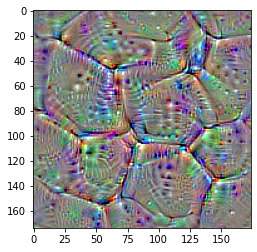

In [11]:
from keras_conv_visualization.filters import FilterVisualization
import matplotlib.pyplot as plt

fv = FilterVisualization(model, (224, 224, 3))
all_imgs = []
loss, img = fv.visualize_filter(0, layer_name)
plt.imshow(img)